# Single-Order Spectrum

This will show how to fit a single-order spectrum using our [previous setup](setup.ipynb) on [WASP14](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=wasp+14&submit=SIMBAD+search) TRES data.

<div class="alert alert-warning">
    
**Warning:** This documentation is a work in progress, please be aware this will change rapidly. 

</div>

In [1]:
%load_ext autoreload
%autoreload 2

## Preprocessing

So the first thing we need to do is pre-process our data. Here we loud the original dataset.

In [2]:
import h5py

with h5py.File('WASP14-2009-12-24.hdf5') as base:
    wls = base['wls'][:]
    fls = base['fls'][:]
    sigmas = base['sigmas'][:]

In [3]:
wls.shape

(51, 2298)

Now I'm going to select a single order to fit, and create a new `Spectrum`

<div class="alert alert-info">
    
**Note:** Fitting only a single order is not the intended use for the `SprectrumModel`, since there are systematics not accounted for (in particular, the Chebyshev polynomial correction). In real use, for a single order you should use an `EchelleModel`, this is just an example.
    
</div>

In [4]:
from Starfish.spectrum import Spectrum

order = 22
wave = wls[order]
flux = fls[order]
sigma = sigmas[order]
# Remove errant absorption. See full dataset for more info
mask = flux < 1e-13 

data = Spectrum(wave, flux, sigma, mask, name=f'WASP 14: Order {order}')
data.save('WASP14_o22.hdf5')

And lets take a look at our data

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['text.usetex'] = True

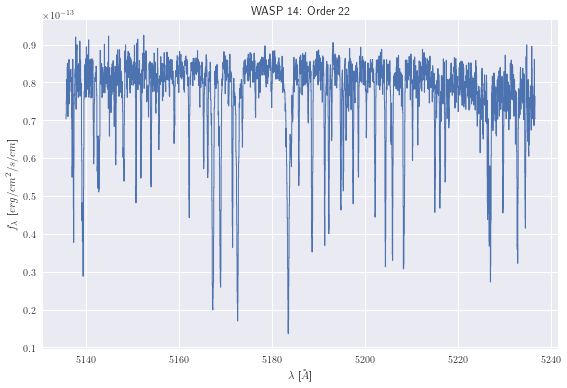

In [9]:
plt.step(data[0].wave, data[0].flux, lw=1)
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')
plt.tight_layout()

## Setting up the model

Now we can set up our initial model. We need, at minimum, an emulator, our data, and a set of the library grid parameters. Every extra keyword argument we add is added to our list of parameters. For more information on what parameters are available and what effect they have, see the [SpectrumModel documentation](). 

Some of these parameters are based on guesses or pre-existing knowledge. In particular, it's important to tune `log_scale` to a reasonable value, so take some iterations of plotting against the data to get a good starting point.

In [44]:
from Starfish.models import SpectrumModel

model = SpectrumModel(
    'F_TRES_emu.hdf5', 
    data,
    grid_params=[6300, 4.29, -0.5],
    log_scale=-13.2,
    vz = 0,
    vsini = 2,
    global_cov = dict(log_amp=0, log_ls=4)
)
model

SpectrumModel
-------------
Data: WASP 14: Order 22
Emulator: F_TRES_emu
Log Likelihood: 12447.041143888062

Parameters
  T: 6300
  Z: -0.5
  global_cov: {'log_amp': 0, 'log_ls': 4}
  log_scale: -13.2
  logg: 4.29
  vsini: 2
  vz: 0

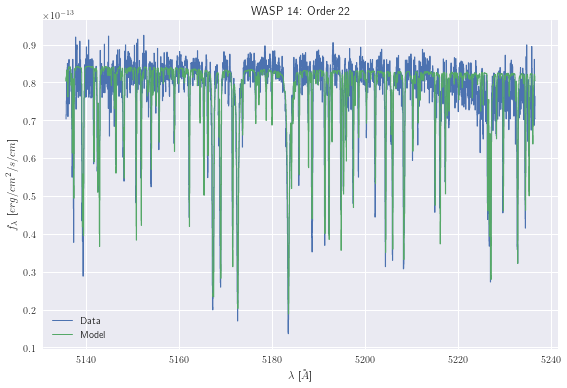

In [45]:
model_flux, model_cov = model()
plt.step(data[0].wave, data[0].flux, lw=1, label='Data')
plt.step(data[0].wave, model_flux, lw=1, label='Model')
plt.legend()
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')
plt.tight_layout()

## Numerical Optimization

Now lets do a *maximum a posteriori* (MAP) point estimate for our data. Note that we freeze `logg` here because the PHOENIX models' response to `logg` compared to our data are relatively flat, so we fix the value using the [freeze]() mechanics.

In [46]:
model.freeze('logg')
# These are the fittable parameters
model.labels

('T',
 'Z',
 'global_cov:log_amp',
 'global_cov:log_ls',
 'log_scale',
 'vsini',
 'vz')

In [47]:
from scipy.optimize import minimize
import scipy.stats as st
import numpy as np

priors = {
    'T': st.uniform(5900, 1300),
    'Z': st.uniform(-1, 1),
    'log_scale': st.norm(-13.2, 0.5),
    'vsini': st.uniform(2, 1e4),
    'vz': st.uniform(-1e4, 2e4),
}

def ll(P):
    model.set_param_vector(P)
    ll = np.sum([priors[key].logpdf(val) for key, val in zip(model.labels, P) if key in priors])
    if not np.isfinite(ll):
        return np.inf
    ll += model.log_likelihood()
    return ll

def nll(P):
    return -ll(P)

In [48]:
P0 = model.get_param_vector()
%time soln = minimize(nll, P0, method='Nelder-Mead', options=dict(maxiter=10000))
soln

/Users/miles/.pyenv/versions/3.7.0/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:596: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


CPU times: user 1min 19s, sys: 5.78 s, total: 1min 24s
Wall time: 1min 8s


 final_simplex: (array([[ 6.49128280e+03, -5.15181175e-01, -5.81007913e-05,
         4.12144940e+00, -1.28882799e+01,  1.93215327e+00,
        -1.14535610e-05],
       [ 6.49128280e+03, -5.15181175e-01, -5.81007913e-05,
         4.12144940e+00, -1.28882799e+01,  1.93215327e+00,
        -1.14535610e-05],
       [ 6.49128280e+03, -5.15181175e-01, -5.81007913e-05,
         4.12144940e+00, -1.28882799e+01,  1.93215327e+00,
        -1.14535610e-05],
       [ 6.49128280e+03, -5.15181175e-01, -5.81007913e-05,
         4.12144940e+00, -1.28882799e+01,  1.93215327e+00,
        -1.14535610e-05],
       [ 6.49128280e+03, -5.15181175e-01, -5.81007913e-05,
         4.12144940e+00, -1.28882799e+01,  1.93215327e+00,
        -1.14535610e-05],
       [ 6.49128280e+03, -5.15181175e-01, -5.81007913e-05,
         4.12144940e+00, -1.28882799e+01,  1.93215327e+00,
        -1.14535610e-05],
       [ 6.49128280e+03, -5.15181175e-01, -5.81007913e-05,
         4.12144940e+00, -1.28882799e+01,  1.93215327e+00,
 

In [49]:
model.set_param_vector(soln.x)
model

SpectrumModel
-------------
Data: WASP 14: Order 22
Emulator: F_TRES_emu
Log Likelihood: 13325.949958448162

Parameters
  T: 6491.282798833821
  Z: -0.5151811745106205
  global_cov: {'log_amp': -5.810079133694295e-05, 'log_ls': 4.121449396084966}
  log_scale: -12.888279883381934
  vsini: 1.9321532694710535
  vz: -1.1453561016243227e-05

Frozen Parameters
  logg: 4.29

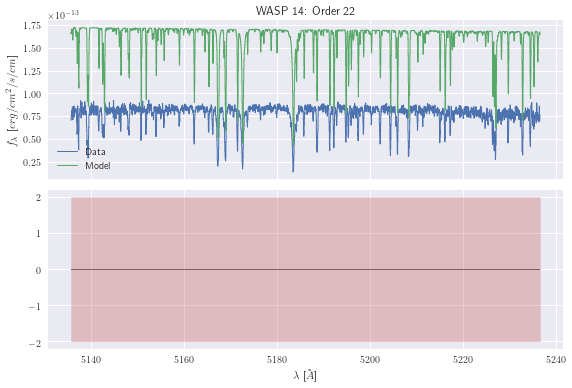

In [50]:
model_flux, model_cov = model()
std = np.sqrt(model_cov.diagonal())

fig, axes = plt.subplots(2, 1, sharex=True)
plt.sca(axes[0])
plt.step(data[0].wave, data[0].flux, lw=1, label='Data')
plt.step(data[0].wave, model_flux, lw=1, label='Model')
plt.legend()
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')

plt.sca(axes[1])
plt.step(data[0].wave, model_flux - data[0].flux, c='k', lw=.5)
plt.fill_between(data[0].wave, 2*std, -2*std, color='C2', alpha=0.3)
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.tight_layout()